In [692]:
import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
import statsmodels.formula.api as sm

In [693]:
# load data from pickle files
AAPL = pickle.load(open("AAPL", "rb"))
C = pickle.load(open("C", "rb"))
GBX = pickle.load(open("GBX", "rb"))
SPY = pickle.load(open("SPY", "rb"))
THO = pickle.load(open("THO", "rb"))

In [733]:
class Orderbook:
    
    def __init__(self, orderbook):
        self.timestamp = orderbook[0]  # seconds after midnight
        orderbook = pd.DataFrame.from_dict(orderbook[1], orient='index')
        orderbook.drop(columns=[2, 3], inplace=True)
        orderbook.reset_index(inplace=True)
        orderbook.columns = ['price', 'quantity', 'side']
        orderbook.sort_values('price', inplace=True)
        buy = orderbook[orderbook.side == 'B'].sort_values('price', ascending=False)  # sort "buy" side orders by price (descending)
        buy['y'] = -buy['quantity'].cumsum()  # buying = selling negative assets
        
        sell = orderbook[orderbook.side == 'S'].sort_values('price', ascending=True)  # sort "sell" side orders by price (ascending)
        sell['y'] = sell['quantity'].cumsum()
        
        orderbook = pd.concat([buy, sell])
        orderbook.sort_values('price', inplace=True)
        self.orderbook = orderbook
        p0 = self.find_p0()  # get midpoint of BBO
        self.orderbook50 = orderbook[(orderbook.price <= p0 * 1.5)  # make a new dataframe that includes only data within 50% of BBO
                               & (orderbook.price >= p0 * 0.5)]
        self.orderbook5 = orderbook[(orderbook.price <= p0 * 1.05)  # make a new dataframe that includes only data within 5% of BBO
                               & (orderbook.price >= p0 * 0.95)]

    def plot(self):
        orderbook50 = self.orderbook50
        plt.plot(orderbook50.price, orderbook50.y, label='Orderbook')  # plot orderbook within 50% of BBO
        plt.xlabel('price')
        plt.ylabel('quantity')
        plt.legend()

    def OLS(self, orderbook):
        result = sm.ols(formula="y ~ price", data=orderbook).fit()  # regress cumulative sum on price
        return result.params
    
    def plot_estimates(self):
        orderbook5 = self.orderbook5
        orderbook50 = self.orderbook50
        ols_params = self.OLS(orderbook5)  # fit linear regression to data within 5% of BBO
        γ = ols_params[0]
        β = ols_params[1]
        estimate = γ + β * orderbook50.price
        plt.plot(orderbook50.price, estimate, label='Estimate')
        plt.xlim(orderbook50.price.min(), orderbook50.price.max())
        plt.ylim(orderbook50.y.min() * 1.1, orderbook50.y.max() * 1.1)
        plt.xlabel('price')
        plt.ylabel('quantity')
        plt.legend()
        
    def find_p0(self):
        orderbook = self.orderbook
        best_offer = orderbook[orderbook.side == 'S'].price.min()
        best_bid = orderbook[orderbook.side == 'B'].price.max()
        return (best_offer + best_bid) / 2  # actual midpoint of BBO

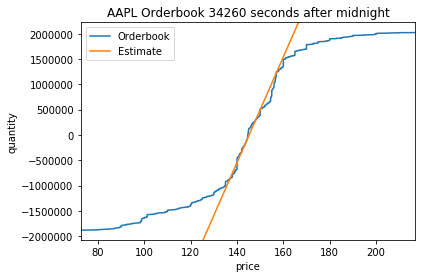

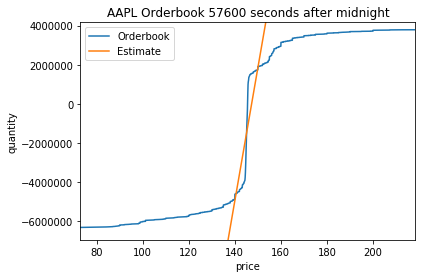

In [752]:
# AAPL Orderbook at 34260 seconds after midnight
aapl_order1 = Orderbook(AAPL[0])
aapl_order1.plot()
aapl_order1.plot_estimates()
plt.title('AAPL Orderbook 34260 seconds after midnight')
plt.show()

# C Orderbook at 57600 seconds after midnight
aapl_order2 = Orderbook(AAPL[-1])
aapl_order2.plot()
aapl_order2.plot_estimates()
plt.title('AAPL Orderbook 57600 seconds after midnight')
plt.show()

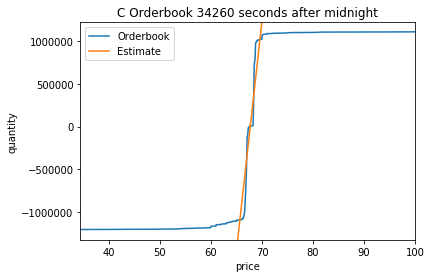

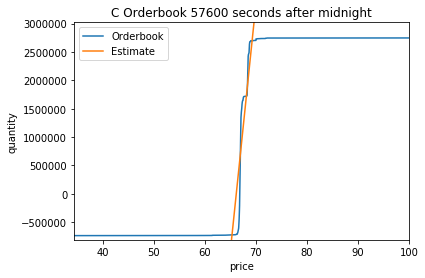

In [753]:
# C Orderbook at 34260 seconds after midnight
c_order1 = Orderbook(C[0])
c_order1.plot()
c_order1.plot_estimates()
plt.title('C Orderbook 34260 seconds after midnight')
plt.show()

# C Orderbook at 57600 seconds after midnight
c_order2 = Orderbook(C[-1])
c_order2.plot()
c_order2.plot_estimates()
plt.title('C Orderbook 57600 seconds after midnight')
plt.show()

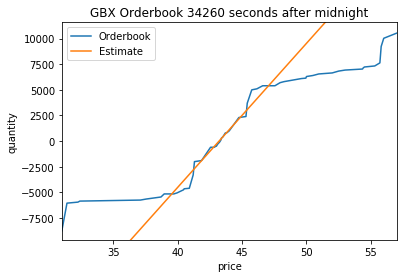

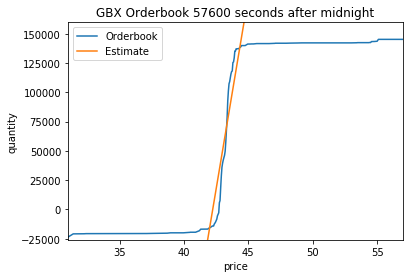

In [736]:
# GBX Orderbook at 34260 seconds after midnight
gbx_order1 = Orderbook(GBX[0])
gbx_order1.plot()
gbx_order1.plot_estimates()
plt.title('GBX Orderbook 34260 seconds after midnight')
plt.show()

# GBX Orderbook at 57600 seconds after midnight
gbx_order2 = Orderbook(GBX[-1])
gbx_order2.plot()
gbx_order2.plot_estimates()
plt.title('GBX Orderbook 57600 seconds after midnight')
plt.show()

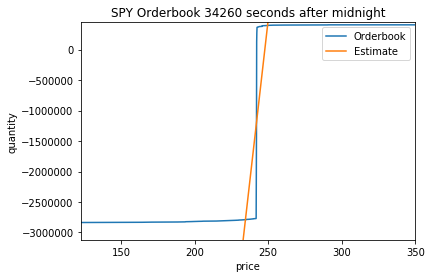

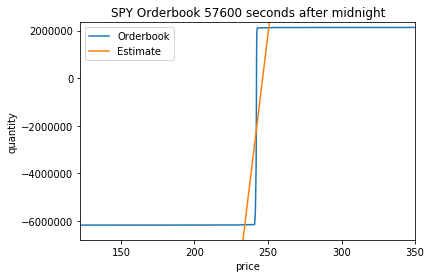

In [737]:
# SPY Orderbook at 34260 seconds after midnight
spy_order1 = Orderbook(SPY[0])
spy_order1.plot()
spy_order1.plot_estimates()
plt.title('SPY Orderbook 34260 seconds after midnight')
plt.show()

# SPY Orderbook at 57600 seconds after midnight
spy_order2 = Orderbook(SPY[-1])
spy_order2.plot()
spy_order2.plot_estimates()
plt.title('SPY Orderbook 57600 seconds after midnight')
plt.show()

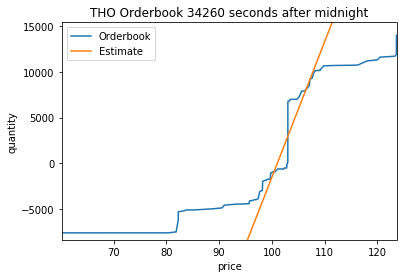

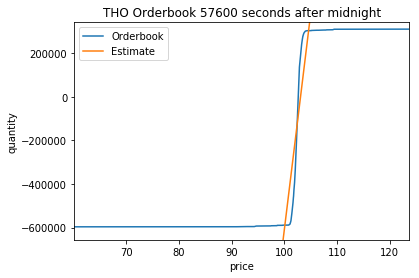

In [738]:
# THO Orderbook at 34260 seconds after midnight
tho_order1 = Orderbook(THO[0])
tho_order1.plot()
tho_order1.plot_estimates()
plt.title('THO Orderbook 34260 seconds after midnight')
plt.show()

# THO Orderbook at 57600 seconds after midnight
tho_order2 = Orderbook(THO[-1])
tho_order2.plot()
tho_order2.plot_estimates()
plt.title('THO Orderbook 57600 seconds after midnight')
plt.show()

The model fits well near the BBO for the orderbook. By restricting the data on which we regress the model, we can plot a more accurate model.

In [754]:
class Ticker:
    
    def __init__(self, orderbooks):
        self.orderbooks = [Orderbook(orderbook) for orderbook in orderbooks]  # all orderbook
        self.timestamps = [orderbook.timestamp for orderbook in self.orderbooks]  # all timestamps
        
    def estimate_β(self):
        orderbooks = self.orderbooks
        β = np.array([orderbook.OLS(orderbook.orderbook5)[1] for orderbook in orderbooks])  # get estimated β for each orderbook
        return β
    
    def estimate_γ(self):
        orderbooks = self.orderbooks
        γ = np.array([orderbook.OLS(orderbook.orderbook5)[0] for orderbook in orderbooks])  # get estimated γ for each orderbook
        return γ
    
    def plot_β(self):
        β = self.estimate_β()  # noise/signal ratio
        plt.plot(self.timestamps, β)
        plt.xlabel('Seconds after midnight')
        plt.ylabel('Noise/Signal Ratio')
        
    def plot_p0_estimates(self):
        β = self.estimate_β()
        γ = self.estimate_γ()
        p0 = - γ / β  # estimate BBO from regression coefficients
        plt.plot(self.timestamps, p0, label='Estimated BBO')
        plt.xlabel('Seconds after midnight')
        plt.ylabel('BB0')
        plt.legend()
    
    def plot_p0(self):
        orderbooks = self.orderbooks
        p0 = np.array([orderbook.find_p0() for orderbook in orderbooks]) # get BBO from data for each orderbook
        plt.plot(self.timestamps, p0, label='BBO from data')
        plt.xlabel('Seconds after midnight')
        plt.ylabel('BBO')
        plt.legend()
        

In [755]:
# create ticker objects
aapl = Ticker(AAPL)
c = Ticker(C)
gbx = Ticker(GBX)
spy = Ticker(SPY)
tho = Ticker(THO)

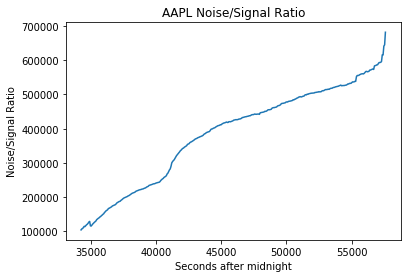

In [756]:
# AAPL Noise/Signal Ratio throughout the day
aapl.plot_β()
plt.title("AAPL Noise/Signal Ratio")
plt.show()

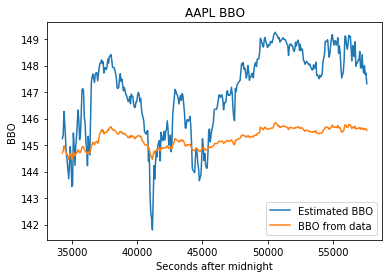

In [757]:
# AAPL BBO throughout the day (estimated and from data)
aapl.plot_p0_estimates()
aapl.plot_p0()
plt.title("AAPL BBO")
plt.show()

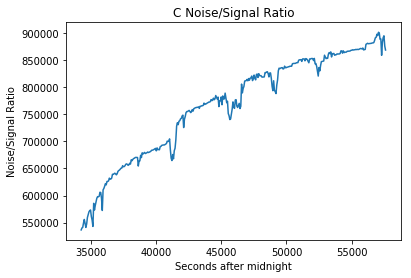

In [758]:
# C Noise/Signal Ratio throughout the day
c.plot_β()
plt.title("C Noise/Signal Ratio")
plt.show()

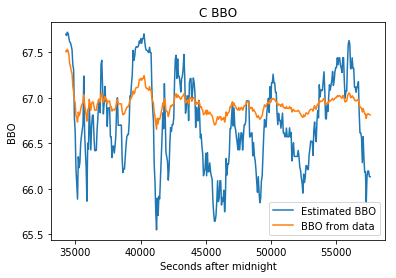

In [759]:
# C BBO throughout the day (estimated and from data)
c.plot_p0_estimates()
c.plot_p0()
plt.title("C BBO")
plt.show()

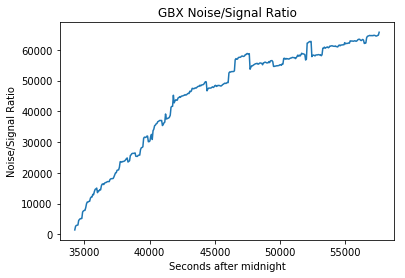

In [760]:
# GBX Noise/Signal Ratio throughout the day
gbx.plot_β()
plt.title("GBX Noise/Signal Ratio")
plt.show()

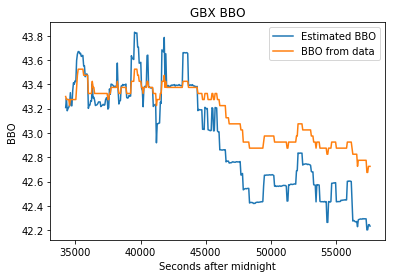

In [761]:
# GBX BBO throughout the day(estimated and from data)
gbx.plot_p0_estimates()
gbx.plot_p0()
plt.title("GBX BBO")
plt.show()

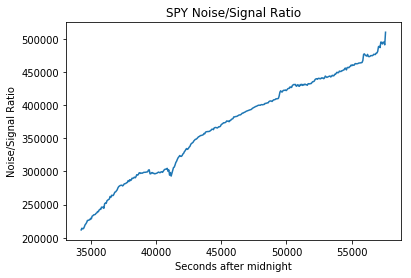

In [762]:
# SPY Noise/Signal Ratio throughout the day
spy.plot_β()
plt.title("SPY Noise/Signal Ratio")
plt.show()

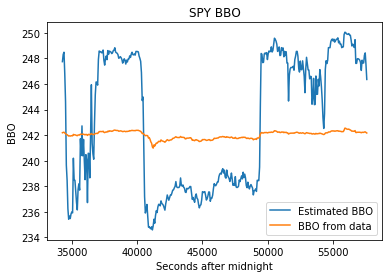

In [763]:
# SPY BBO throughout the day (estimated and from data)
spy.plot_p0_estimates()
spy.plot_p0()
plt.title("SPY BBO")
plt.show()

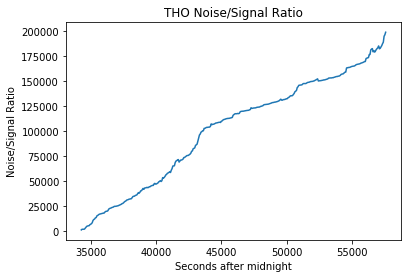

In [764]:
# THO Noise/Signal Ratio throughout the day
tho.plot_β()
plt.title("THO Noise/Signal Ratio")
plt.show()

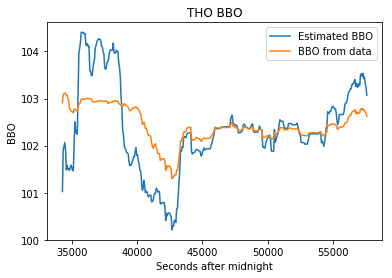

In [765]:
# THO BBO throughout the day (estimated and from data)
tho.plot_p0_estimates()
tho.plot_p0()
plt.title("THO BBO")
plt.show()

In most cases, the estimated and actual BBO move in similar trends, though the estimates of $p_0$ vary significantly more over throughout the day, while the actual midpoints of the BBO vary less. 

The noise/signal ratios that I would have expected to increase the most compared to their initial values were AAPL, GBX, and THO, since the slopes of the regressions from the first orderbook of the day to the last increased noticeably. Conversely, C and SPY had high noise/signal ratios in the first orderbook and did not increase as substantially.